# Normal model for basketball scores (using MCMC sampling)

In [1]:
import pandas as pd, numpy as np, scipy as sp, matplotlib.pyplot as plt, pymc3 as pm
from scipy import stats
from sklearn.preprocessing import StandardScaler
import plot_tools

In [2]:
bball = pd.read_csv('../../data/basketball.csv')
bball.head()
modern = bball[bball['Year'] > 1960]

In [3]:
# Get some subsamples
modern_era = bball[bball['Year']>=1987]
sample_small = modern_era.iloc[np.random.choice(len(modern_era), 10)]    # 10 games
sample_med = modern_era.iloc[np.random.choice(len(modern_era), 40)]    # 40 games
sample_large = modern_era.iloc[np.random.choice(len(modern_era), 100)]    # 100 games

mean_small = sample_small['Combined'].mean()
mean_med = sample_med['Combined'].mean()
mean_large = sample_large['Combined'].mean()

sd_small = sample_small['Combined'].std()
sd_med = sample_small['Combined'].std()
sd_large = sample_small['Combined'].std()

### Known variance case

In [4]:
with pm.Model() as normal_model_known:
    # Priors for parameters
    mean = pm.Normal('mu', mu=200, sigma=100)
    
    # Likelihood
    score = pm.Normal('score', mu = mean, sigma = 24, observed = sample_large['Combined'])
    
    # Inference
    trace = pm.sample(2000, target_accept = 0.9, tune = 1000)
    summary = pm.summary(trace)

<ipython-input-4-2a669ba03544>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, target_accept = 0.9, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


(array([  15.,  124.,  539., 1539., 2393., 2079.,  955.,  297.,   51.,
           8.]),
 array([142.83251291, 144.69277258, 146.55303225, 148.41329193,
        150.2735516 , 152.13381127, 153.99407095, 155.85433062,
        157.71459029, 159.57484997, 161.43510964]),
 <BarContainer object of 10 artists>)

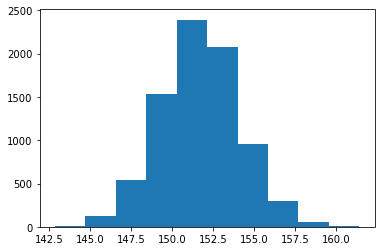

In [5]:
plt.hist(trace['mu'])

In [6]:
pm.summary(trace)

/home/dylan/.conda/envs/info510/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,151.69,2.414,147.159,156.272,0.044,0.031,2958.0,4007.0,1.0


### Unknown variance

In [17]:
with pm.Model() as normal_model_unknown:
    # Priors for parameters
    mu = pm.Flat('mu')
    sigma_log = pm.Flat('sigma_log')
    sigma = pm.Deterministic('sigma', pm.math.exp(sigma_log))
    #sigma = pm.math.exp(sigma_log)
    
    # Likelihood
    score = pm.Normal('score', mu = mu, sigma = sigma, observed = sample_large['Combined'])
    
    # Inference
    trace = pm.sample(2000, target_accept = 0.9, tune = 1000)
    summary = pm.summary(trace)

<ipython-input-17-650c086455ba>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, target_accept = 0.9, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


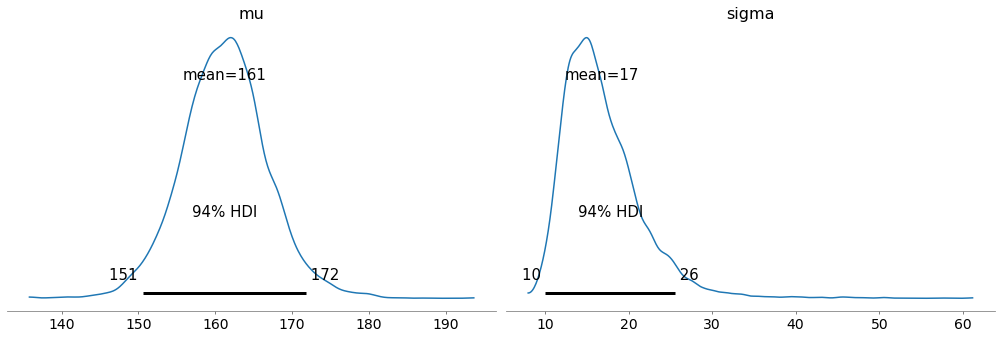

In [8]:
with normal_model_unknown:
    pm.plot_posterior(trace, var_names=['mu', 'sigma'])

In [9]:
pm.summary(trace)

/home/dylan/.conda/envs/info510/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,161.198,5.615,150.528,171.846,0.087,0.062,4357.0,3290.0,1.0
sigma_log,2.788,0.257,2.334,3.266,0.004,0.003,3617.0,3732.0,1.0
sigma,16.831,4.796,10.054,25.593,0.088,0.068,3617.0,3732.0,1.0


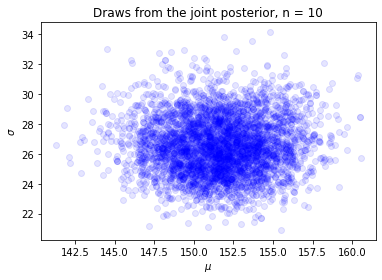

In [18]:
plt.figure()
plt.plot(trace['mu'][:4000], trace['sigma'][:4000], 'o', color = 'blue', alpha = 0.1)
plt.title('Draws from the joint posterior, n = 10')
#plt.xlim(100, 200)
#plt.ylim(20, 50)
plt.xlabel('$\\mu$')
plt.ylabel('$\\sigma$')
plt.show()

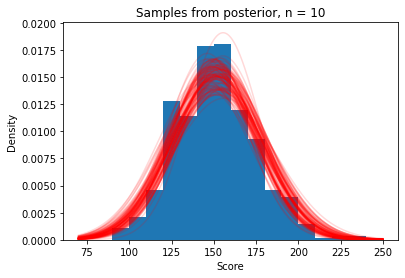

In [19]:
plt.figure()
plt.hist(modern_era['Combined'], density = True, bins = range(70, 250, 10))
x = np.linspace(70, 250, 5000)
for i in range(100):
    y = sp.stats.norm.pdf(x, trace['mu'][i], trace['sigma'][i])
    plt.plot(x, y, color = 'red', alpha = 0.15)

plt.title('Samples from posterior, n = 10')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

## Posterior predictive checking

In [20]:
with normal_model_unknown:
    replications = pm.sample_posterior_predictive(trace)

In [21]:
replications['score'].shape

(8000, 100)

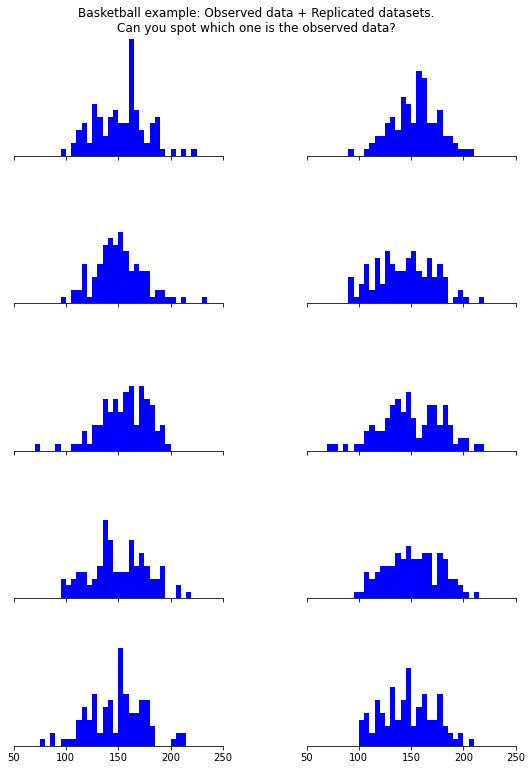

In [22]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
np.random.seed(824792)
order = np.random.permutation(10)
choices = np.random.permutation(8000)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replications['score'][choices[i]] if order[i] < 9 else sample_large['Combined'],
        np.arange(50, 250, 5),
        #color = 'blue' if order[i] < 9 else 'red'
        color = 'blue'
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([50, 250])
fig.suptitle(
    "Basketball example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

In [25]:
mins = np.min(replications['score'], axis = 1)
maxs = np.max(replications['score'], axis = 1)

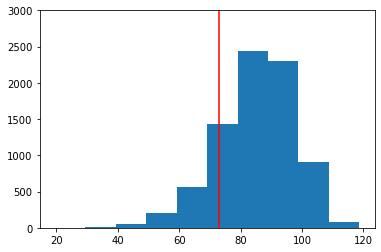

In [30]:
plt.hist(mins)
plt.ylim((0, 3000))
plt.vlines(x=modern['Combined'].min(), ymin=0, ymax=8000, color = 'red')

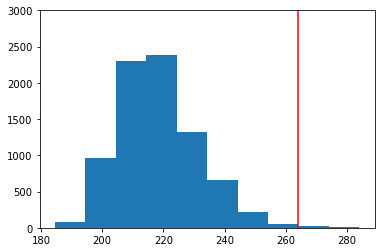

In [33]:
plt.hist(maxs)
plt.ylim((0, 3000))
plt.vlines(x=modern['Combined'].max(), ymin=0, ymax=3000, color = 'red')

In [ ]:
modern['Combined'].sort_values()

In [ ]:
modern.loc[1370]